In [1]:
import stroboscope_model as strob
import numpy as np
import sdeint
import deepdish.io as dd
from scipy.integrate import solve_ivp
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import time
from IPython.display import set_matplotlib_formats
from ipywidgets import interact, interactive,FloatSlider,IntSlider,ToggleButton
from ipywidgets import Button, HBox, VBox, Text,Select,Layout,Dropdown
set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 75

plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = "sans"
plt.rcParams['font.serif'] = "cm"

In [15]:
Tmax = 17.75

In [2]:
m = strob.BenincaModel(Es=strob.Es_normal,Ps='auto/Beninca_set1.hdf5',Vs=None)
init_cond = strob.calc_for_constant(m)
print("Initial conditions:",init_cond)

dB0dt =  -A*B0*cAB - B0*M*cM - B0*mB + BA*mA*(alpha*(Tmax - Tmean)*cos(0.01721420632104*t - 0.550854602273279) + 1.0) + cBR*(B0 + BA)*(-A - B0 - M + 1.0)
dBAdt =  A*B0*cAB - BA*M*cM - BA*mA*(alpha*(Tmax - Tmean)*cos(0.01721420632104*t - 0.550854602273279) + 1.0) - BA*mB
dAdt  =  A*B0*cAB - A*M*cM + A*cAR*(-A - B0 - M + 1.0) - A*mA*(alpha*(Tmax - Tmean)*cos(0.01721420632104*t - 0.550854602273279) + 1.0)
dMdt  =  M*cM*(A + B0) - M*mM*(alpha*(Tmax - Tmean)*cos(0.01721420632104*t - 0.550854602273279) + 1.0)
Local Jacobian: Matrix([[-A*cAB - M*cM - cBR*(B0 + BA) + cBR*(-A - B0 - M + 1.0) - mB, cBR*(-A - B0 - M + 1.0) + mA*(alpha*(Tmax - Tmean)*cos(0.01721420632104*t - 0.550854602273279) + 1.0), -B0*cAB - cBR*(B0 + BA), -B0*cM - cBR*(B0 + BA)], [A*cAB, -M*cM - mA*(alpha*(Tmax - Tmean)*cos(0.01721420632104*t - 0.550854602273279) + 1.0) - mB, B0*cAB, -BA*cM], [A*cAB - A*cAR, 0, -A*cAR + B0*cAB - M*cM + cAR*(-A - B0 - M + 1.0) - mA*(alpha*(Tmax - Tmean)*cos(0.01721420632104*t - 0.55085460227327

In [3]:
int_finish=100*365
trim=70*365
finish = int(int_finish*1.0)

In [16]:
step=0.01
ito = 0.0
tspan,result,forcing=strob.calc_for_oscillation_with_Ito(m,init_cond,Tmax,ito,int_finish,step)

Tmax=17.75


In [17]:
var_index=0
peaks_signal, _=find_peaks(result[trim:,var_index])
peaks_forcing, _=find_peaks(forcing[trim:])
print(peaks_forcing.shape)
print(peaks_signal.shape)


(99,)
(99,)


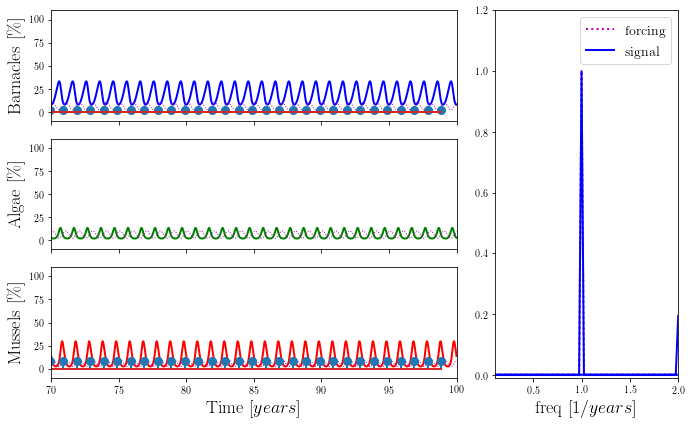

In [18]:
fig,ax=plt.subplots(1,2,figsize=(6*1.618,6))
gs = gridspec.GridSpec(3, 3)
ax3 = plt.subplot(gs[2:,:-1])
ax1 = plt.subplot(gs[0, :-1])#, sharey=ax3, sharex=ax3)
ax2 = plt.subplot(gs[1, :-1])#, sharey=ax3, sharex=ax3)
ax4 = plt.subplot(gs[:, -1])
forcing_tspan = m.Ft(tspan)
plot_forcing_tspan = 10.0*forcing_tspan/np.amax(forcing_tspan)
ax1.plot(tspan/365,(result[:,0]+result[:,1])*100.0,'b',label=r'Barnacles')
ax2.plot(tspan/365,result[:,2]*100.0,'g',label=r'Algae')
ax3.plot(tspan/365,result[:,3]*100.0,'r',label=r'Mussels')
ax1.plot(tspan/365,plot_forcing_tspan,'m:',label=r'forcing',lw=1)
ax2.plot(tspan/365,plot_forcing_tspan,'m:',label=r'forcing',lw=1)
ax3.plot(tspan/365,plot_forcing_tspan,'m:',label=r'forcing',lw=1)
ax1.set_ylabel(r'Barnacles $[\%]$')
ax1.axes.xaxis.set_ticklabels([])
ax2.axes.xaxis.set_ticklabels([])
#ax3.axes.xaxis.set_ticklabels(np.arange(30,51,1))
ax2.set_ylabel(r'Algae $[\%]$')
ax3.set_ylabel(r'Mussels $[\%]$')
ax3.set_xlabel(r'Time $[years]$')
ax1.set_xlim([trim/365,tspan[-1]/365])
ax2.set_xlim([trim/365,tspan[-1]/365])
ax3.set_xlim([trim/365,tspan[-1]/365])
ax1.set_ylim([-10,110])
ax2.set_ylim([-10,110])
ax3.set_ylim([-10,110])
# FFT
forcing = m.Ft(tspan)
#print(len(forcing))
trimfft = int(len(forcing)*(2.0/5.0)) # the index from which to trim the time series to clean transients
#print(trim)
frq = np.fft.fftfreq(forcing[-trimfft:].size,d=0.01/365)
fft_forcing = np.absolute((np.fft.fft(forcing[-trimfft:])))
fft_signal  = np.absolute((np.fft.fft(result[-trimfft:,0])))
normalize_fft = np.amax(fft_signal[1:])
ax4.plot(frq[1:],fft_forcing[1:]/np.amax(fft_forcing[1:]),'m:',label=r'forcing')
ax4.plot(frq[1:],fft_signal[1:]/normalize_fft,'b',label=r'signal')
ax4.set_xlim([0.1,2.0])
ax4.set_ylim([-0.01,1.2])
ax4.set_xlabel(r'freq $[1/years]$')
ax3.stem(tspan[peaks_forcing]/365,(result[trim:,3])[peaks_forcing]*100.0)
ax1.stem(tspan[peaks_forcing]/365,(plot_forcing_tspan[trim:])[peaks_forcing])
#ax[0].legend(loc='upper left')
ax4.legend(loc='upper right')
#ax[0].legend(loc='upper left')
#ax[1].legend(loc='upper left')
plt.tight_layout()